In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# load the list of images then initialize the data (i.e., images) and image's labels
imagePaths = list(paths.list_images(r"C:\Users\Abhishek\Downloads\face-mask-detector\dataset"))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [3]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [4]:
# partition 80% of the data for training and the remaining 20% for testing
trainX, testX, trainY, testY = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [5]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,
                         width_shift_range=0.2,height_shift_range=0.2,
                         shear_range=0.15,horizontal_flip=True,
                         fill_mode="nearest")

In [9]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [10]:
# loop over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [12]:
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [13]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("[INFO] compiled")

[INFO] compiling model...
[INFO] compiled


In [14]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),
              steps_per_epoch=len(trainX) // BS,
              validation_data=(testX, testY),
              validation_steps=len(testX) // BS,
              epochs=EPOCHS)
print("[INFO] model is ready")

[INFO] training head...
Epoch 1/20
34/34 [==============================] - 11s 323ms/step - loss: 0.4848 - accuracy: 0.7575 - val_loss: 0.1558 - val_accuracy: 0.9601
Epoch 2/20
34/34 [==============================] - 9s 265ms/step - loss: 0.1366 - accuracy: 0.9616 - val_loss: 0.0826 - val_accuracy: 0.9710
Epoch 3/20
34/34 [==============================] - 9s 265ms/step - loss: 0.0840 - accuracy: 0.9770 - val_loss: 0.0548 - val_accuracy: 0.9855
Epoch 4/20
34/34 [==============================] - 9s 261ms/step - loss: 0.0558 - accuracy: 0.9869 - val_loss: 0.0408 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 9s 254ms/step - loss: 0.0438 - accuracy: 0.9897 - val_loss: 0.0342 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 9s 251ms/step - loss: 0.0335 - accuracy: 0.9945 - val_loss: 0.0275 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 9s 252ms/step - loss: 0.0296 - accuracy: 0.9925 - val_loss: 0.0241 - va

In [15]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       1.00      0.99      1.00       138
without_mask       0.99      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [17]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("detector.model", save_format="h5")

[INFO] saving mask detector model...


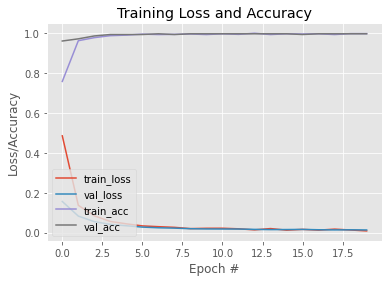

In [18]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [20]:
plt.savefig("pic.png")

<Figure size 432x288 with 0 Axes>